<a href="https://colab.research.google.com/github/salmanarif86/MLAI/blob/master/Stock_Market_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob, os
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from matplotlib.dates import MonthLocator, YearLocator
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

Reading the S&P 500 as a dataframe and then picking up Adjusted Close price and Date  

In [0]:
SPY = pd.read_csv('/content/SPY.csv')[['Date','Adj Close']]

The data in the csv is from 2010 to 2020. However for our analysis we will take take data from Feb 2nd, 2017. We will use 1 year of historical data [2017-02-01 - 2018-02-01] training and then predict daily prices 3 months ahead in time. They are a total of 252 trading days of data in the csv file per year

In [0]:
SPY['Date'][0:253]

0      2010-01-04
1      2010-01-05
2      2010-01-06
3      2010-01-07
4      2010-01-08
          ...    
248    2010-12-28
249    2010-12-29
250    2010-12-30
251    2010-12-31
252    2011-01-03
Name: Date, Length: 253, dtype: object

The below helper function will take timeseries data from the csv file parse Date and Adj Close and return historical data specified by the function attribute 'index'

In [0]:
def parse_timeseries(loc, index):
  df = pd.read_csv(loc)[['Date','Adj Close']]
  return df[-index :].reset_index() #Using index parsing to obtain data from 2017-02-01


In [0]:
SPY = parse_timeseries('/content/SPY.csv', 735)

The graph below is already showing alot and we can see huge swing in the downward direction during []. However the long term trend or drift has been generally upwards

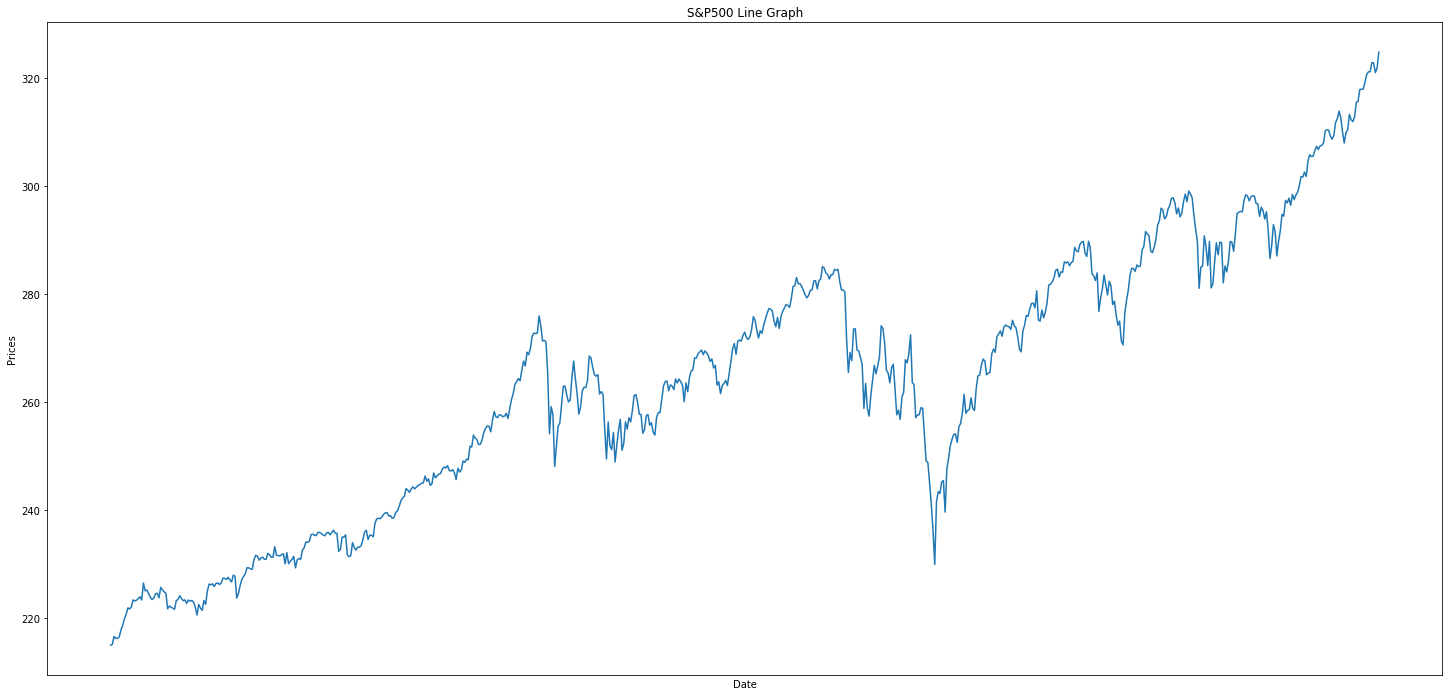

In [0]:
fig, ax = plt.subplots(figsize=(25,12))
ax.plot(SPY['Date'].values, SPY['Adj Close'])
ax.set(xlabel="Date", ylabel="Prices",
       title="S&P500 Line Graph")

# Define the date format
date_form = DateFormatter("%m/%d")
ax.xaxis.set_major_formatter(date_form)
# Ensure ticks fall once every other week (interval=2) 
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=10))



**Splitting Data into a Training set and a Test set**

The training data will be the first 252 trading days data series and the test would be next 90 days. The following helper function splits the data into train_test_split and also converts it into a matrix for easy data wrangling

In [0]:
def train_test_split(df,TrainDateTo, TestDateTo):
  train_data = df[:TrainDateTo]
  test_data = df[TrainDateTo: TrainDateTo + TestDateTo]
  return [train_data, test_data]

In [0]:
train_data, test_data =train_test_split(SPY,253,90)

**Normalizing the Data**
Now you need to define a scaler to normalize the data. MinMaxScalar scales all the data to be in the region of 0 and 1. You can also reshape the training and test data to be in the shape [data_size, num_features]. when scaling remember you always normalize both test and train with respoct to training data because you dont have access to test data

In [0]:
train_data

,index,Date,Adj Close
0,1782,2017-02-01,215.045044
1,1783,2017-02-02,215.186752
2,1784,2017-02-03,216.670013
3,1785,2017-02-06,216.282684
4,1786,2017-02-07,216.292145
...,...,...,...
248,2030,2018-01-26,276.011414
249,2031,2018-01-29,274.181458
250,2032,2018-01-30,271.369202
251,2033,2018-01-31,271.504028


In [0]:
scaler = StandardScaler()
train_data_matrix = train_data['Adj Close'].as_matrix().reshape(-1,1)
test_data_matrix = test_data['Adj Close'].as_matrix().reshape(-1,1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
train_data_matrix

array([[215.045044],
       [215.186752],
       [216.670013],
       [216.282684],
       [216.292145],
       [216.575546],
       [217.860382],
       [218.720123],
       [219.910522],
       [220.789154],
       [221.941727],
       [221.752823],
       [222.102325],
       [223.424988],
       [223.226578],
       [223.377762],
       [223.661209],
       [224.010757],
       [223.406097],
       [226.533249],
       [225.106689],
       [225.248367],
       [224.577637],
       [223.906815],
       [223.49115 ],
       [223.774582],
       [224.558701],
       [224.672104],
       [223.812347],
       [225.7491  ],
       [225.305069],
       [224.909409],
       [224.662704],
       [221.778107],
       [222.300003],
       [222.062805],
       [221.901489],
       [221.673767],
       [223.286835],
       [223.495605],
       [224.207199],
       [223.685364],
       [223.296341],
       [223.438644],
       [222.774445],
       [223.400711],
       [223.172974],
       [223.3

Due to the observation we made earlier, that is, different time periods of data have different value ranges, you normalize the data by splitting the full series into windows. If you don't do this, the earlier data will be close to 0 and will not add much value to the learning process. Here you choose a window size of 50

**Note :** when choosing the window size make sure it's not too small, because when you perform windowed-normalization, it can introduce a break at the very end of each window, as each window is normalized independently.

In this example, 5 data points will be affected by this as we have a total of 252 data points

In [0]:
# Train the Scaler with training data and smooth data
smoothing_window_size = 10
for di in range(0,250,smoothing_window_size):
    scaler.fit(train_data_matrix[di:di+smoothing_window_size,:])
    train_data_matrix[di:di+smoothing_window_size,:] = scaler.transform(train_data_matrix[di:di+smoothing_window_size,:])
    

# You normalize the last bit of remaining data
scaler.fit(train_data_matrix[di+smoothing_window_size:,:])
train_data_matrix[di+smoothing_window_size:,:] = scaler.transform(train_data_matrix[di+smoothing_window_size:,:])



In [0]:
# Reshape both train and test data
train_data = train_data_matrix.reshape(-1)

In [0]:
# Normalize test data
test_data = scaler.fit_transform(test_data_matrix).reshape(-1)

You can now smooth the data using the exponential moving average. This helps you to get rid of the inherent raggedness of the data in stock prices and produce a smoother curve.

Note that you should only smooth training data.

In [0]:
# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
EMA = 0.0
gamma = 0.1
for ti in range(253):
  EMA = gamma*train_data[ti] + (1-gamma)*EMA
  train_data[ti] = EMA

all_adj_data = np.concatenate([train_data,test_data],axis=0)

**One-Step Ahead Prediction via Averaging**

We would like to set some Naive-benchmarks like simple-averaging to compare against more advanced deep learning algorithms. We can use simple Averaging to predict often one time step ahead by reprsenting the future stock prices as an average of some historical average. We will perform two Naive Averaging procedures 'Simple Moving Average' and 'Exponential Moving Average'

We will evaluate the result visually and quantitavely (Mean Squared Error).The Mean Squared Error (MSE) can be calculated by taking the Squared Error between the true value at one step ahead and the predicted value and averaging it over all the predictions.

**Training**

In [0]:
window_size = 10
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):

    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = SPY.loc[pred_idx,'Date']

    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for standard averaging: 0.01727


**Visualize Training**

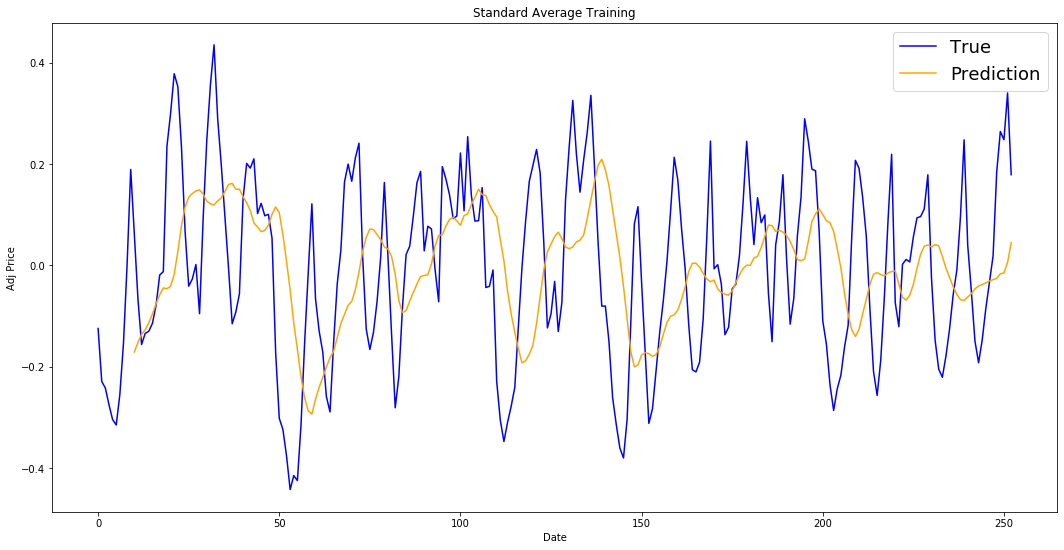

In [0]:
plt.figure(figsize = (18,9))
plt.plot(range(253),all_adj_data[:253],color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Adj Price')
plt.title('Standard Average Training')

plt.legend(fontsize=18)
plt.show()

**Testing**

In [0]:
window_size = 10
N = test_data.size
std_avg_predictions_test = []
std_avg_x_test = []
mse_errors_test = []

for pred_idx in range(window_size,N):

    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = SPY.loc[pred_idx,'Date']

    std_avg_predictions_test.append(np.mean(test_data[pred_idx-window_size:pred_idx]))
    mse_errors_test.append((std_avg_predictions_test[-1]-test_data[pred_idx])**2)
    std_avg_x_test.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors_test)))

MSE error for standard averaging: 0.33669


**Visualize Testing**

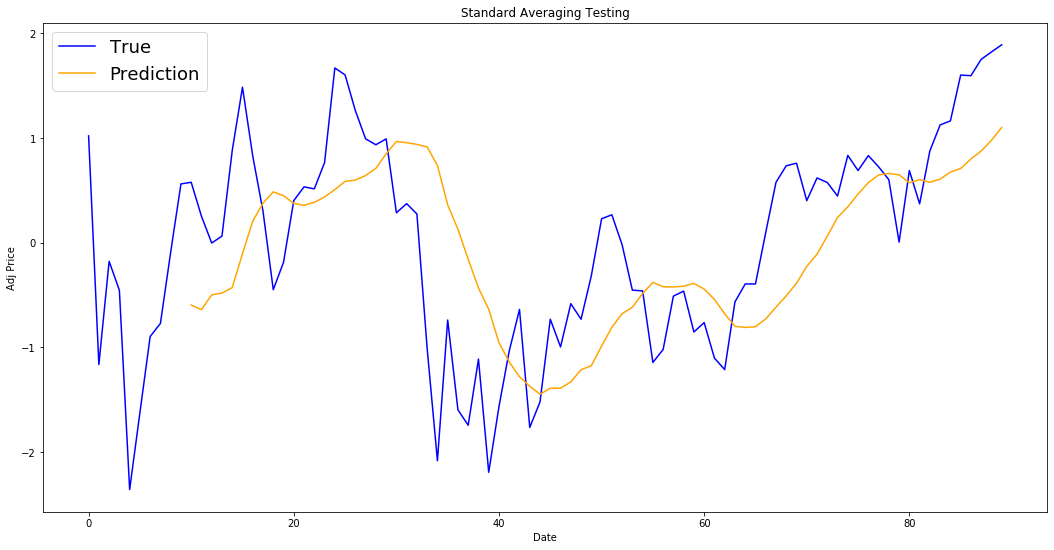

In [0]:
plt.figure(figsize = (18,9))
plt.plot(range(0,90),all_adj_data[253:],color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions_test,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Adj Price')
plt.title('Standard Averaging Testing')

plt.legend(fontsize=18)
plt.show()

**Inverse the Scale back**

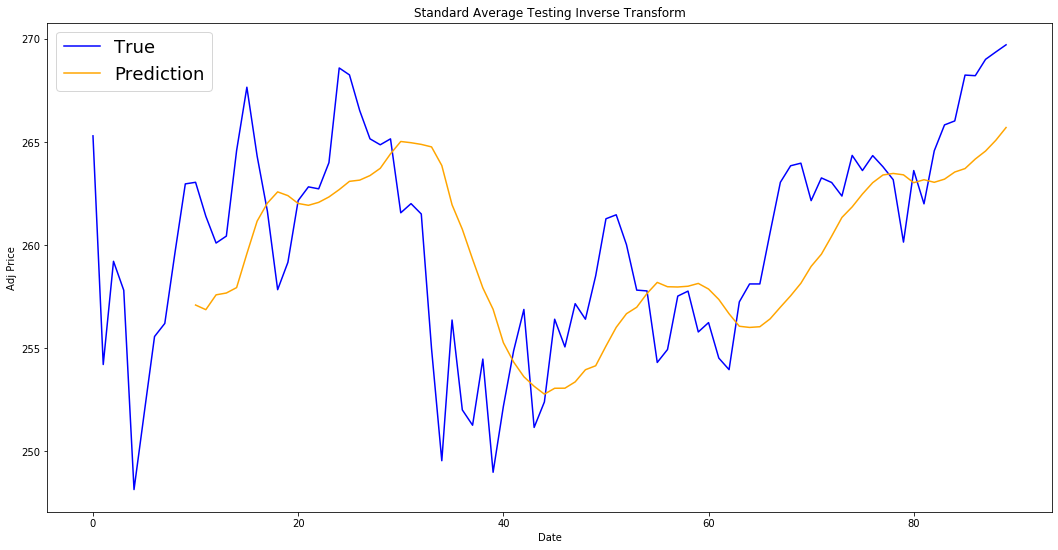

In [0]:
plt.figure(figsize = (18,9))
plt.plot(range(0,90),scaler.inverse_transform(all_adj_data[253:]),color='b',label='True')
plt.plot(range(window_size,N),scaler.inverse_transform(std_avg_predictions_test),color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Adj Price')
plt.title('Standard Average Testing Inverse Transform')
plt.legend(fontsize=18)
plt.show()

**Exponential Moving Average**

The exponential moving average calculates average from t+1 time step and uses that as the one step ahead prediction. γ decides what the contribution of the most recent prediction is to the EMA. For example, a γ=0.1 gets only 10% of the current value into the EMA. Because you take only a very small fraction of the most recent, it allows to preserve much older values you saw very early in the average. See how good this looks when used to predict one-step ahead below.

**Training**

In [0]:
window_size = 10
N = train_data.size

run_avg_predictions = []
run_avg_x = []

mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5

for pred_idx in range(1,N):

    running_mean = running_mean*decay + (1.0-decay)*train_data[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-train_data[pred_idx])**2)
    run_avg_x.append(date)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for EMA averaging: 0.00889


**Visualize Training**

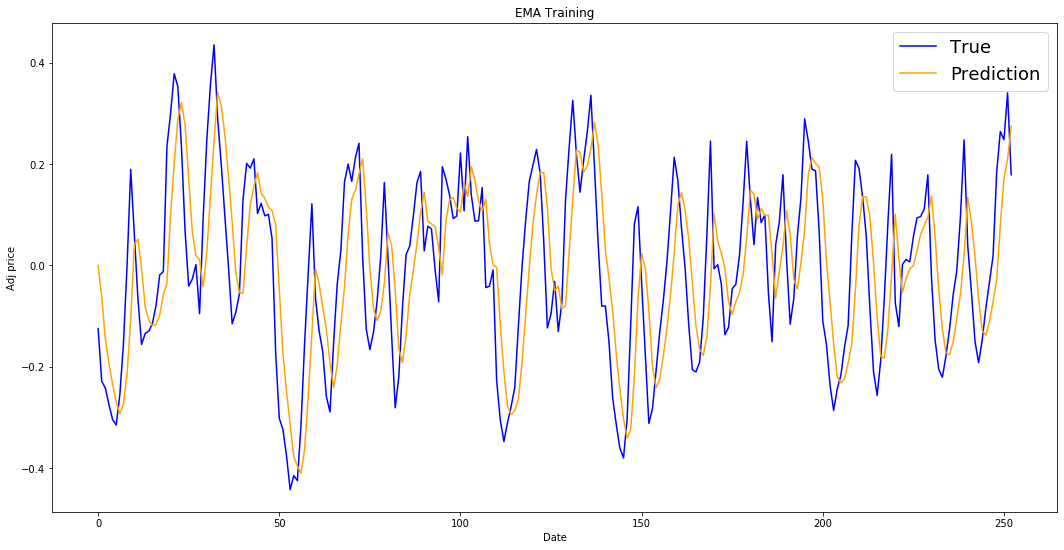

In [0]:
plt.figure(figsize = (18,9))
plt.plot(range(253),all_adj_data[:253],color='b',label='True')
plt.plot(range(0,N),run_avg_predictions,color='orange', label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Adj price')
plt.title('EMA Training')
plt.legend(fontsize=18)
plt.show()

**Testing**

In [0]:
window_size = 10
N = test_data.size

run_avg_predictions_test = []
run_avg_x_test = []

mse_errors_test = []

running_mean_test = 0.0
run_avg_predictions_test.append(running_mean_test)

decay = 0.5

for pred_idx in range(1,N):

    running_mean_test = running_mean_test*decay + (1.0-decay)*test_data[pred_idx-1]
    run_avg_predictions_test.append(running_mean_test)
    mse_errors_test.append((run_avg_predictions_test[-1]-train_data[pred_idx])**2)
    run_avg_x_test.append(date)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors_test)))

MSE error for EMA averaging: 0.36702


In [0]:
prediction_file_EMA(SPY,'/content/sample_data/SPY_pred.csv')

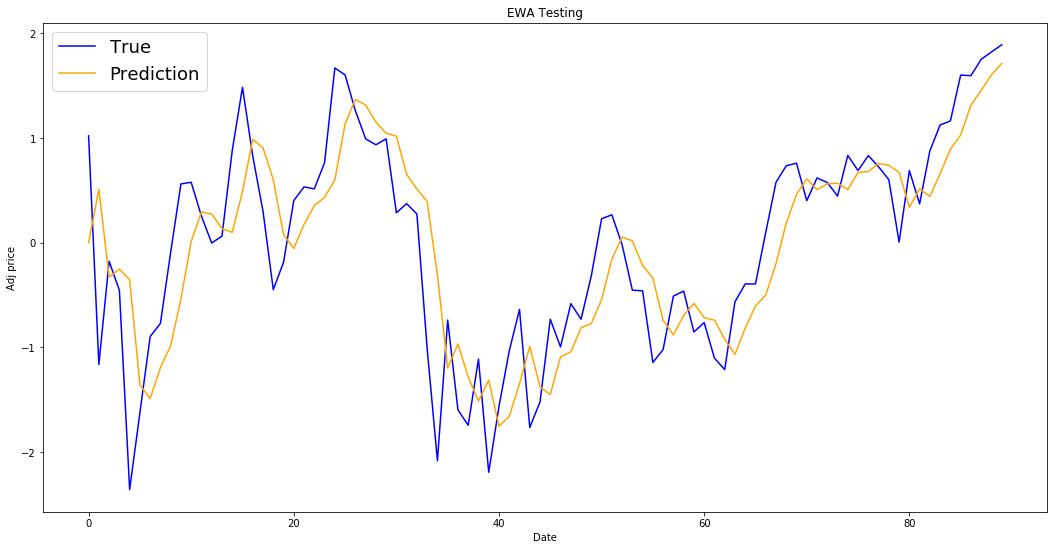

In [0]:
plt.figure(figsize = (18,9))
plt.plot(range(0,90),all_adj_data[253:],color='b',label='True')
plt.plot(range(0,N),run_avg_predictions_test,color='orange', label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Adj price')
plt.title('EWA Testing')
plt.legend(fontsize=18)
plt.show()

**Inverse the Scale back**

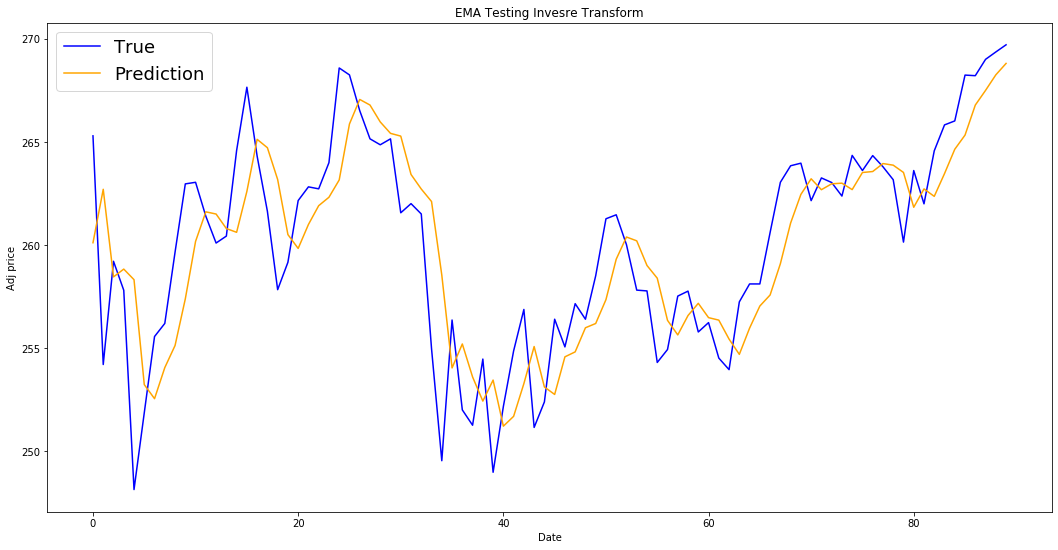

In [0]:
plt.figure(figsize = (18,9))
plt.plot(range(0,90),scaler.inverse_transform(all_adj_data[253:]),color='b',label='True')
plt.plot(range(0,N),scaler.inverse_transform(run_avg_predictions_test),color='orange', label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Adj price')
plt.title('EMA Testing Invesre Transform')
plt.legend(fontsize=18)
plt.show()

This is a helper function to get the prediction file per stock

In [0]:
def prediction_file_EMA(df, loc):
  EMA_testing = pd.DataFrame(scaler.inverse_transform(run_avg_predictions_test),columns=['EMA Adj Price'])
  Label = df[253: 253+90].drop(columns='index').reset_index()
  df = Label.join(EMA_testing)
  export_csv = df.to_csv (loc, index = None, header=True)

In [0]:
prediction_file_EMA(SPY,'/content/sample_data/test.csv')

In [0]:
def create_data(loc, timesteps):
  path = loc                 
  all_files = glob.glob(os.path.join(path, "*.csv"))
  df_from_each_file = (pd.read_csv(f)[['Date','Adj Close']] for f in all_files)
  concatenated_df   = pd.concat(df_from_each_file, ignore_index=True,axis=1,)
  concatenated_df = concatenated_df.drop(columns=concatenated_df.columns.values[2::2].tolist())
  concatenated_df = concatenated_df[-timesteps:]
  return concatenated_df

  
  
  
  #concatenated_df.columns.values[1:] = [os.path.basename(f) for f in all_files]




In [0]:
concatenated_df.columns=['Date','RWR','IYT','XLB','XLP','XLV','XLE','XLF','XLI','XLY','XLK','SPY','XLU']

In [0]:
def train_test_split(df,TrainDateTo, TestDateTo):
  train_data = df[:TrainDateTo]
  test_data = df[TrainDateTo: TrainDateTo + TestDateTo]
  return [train_data, test_data]

In [0]:
df = create_data(r'/content/', 735)

In [0]:
train_data, test_data =train_test_split(df,253,90)

In [0]:
# Train the Scaler with training data and smooth data
smoothing_window_size = 10
for di in range(0,250,smoothing_window_size):
    scaler.fit(train_data_matrix[di:di+smoothing_window_size,:])
    train_data_matrix[di:di+smoothing_window_size,:] = scaler.transform(train_data_matrix[di:di+smoothing_window_size,:])
    

# You normalize the last bit of remaining data
scaler.fit(train_data_matrix[di+smoothing_window_size:,:])
train_data_matrix[di+smoothing_window_size:,:] = scaler.transform(train_data_matrix[di+smoothing_window_size:,:])

NameError: ignored

In [0]:
scaler = StandardScaler()
train_data_matrix = train_data['RWR','IYT','XLB','XLP','XLV','XLE','XLF','XLI','XLY','XLK','SPY','XLU'].as_matrix().reshape(-1,1)
test_data_matrix = test_data.as_matrix().reshape(-1,1)

KeyError: ignored

3289